In [89]:
import numpy

import iris
iris.FUTURE.netcdf_promote = True

import iris.plot as iplt
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

import calendar
import iris.coord_categorisation

In [2]:
%matplotlib inline

In [24]:
access_pr_file = 'pr_Amon_ACCESS1-3_historical_r1i1p1_198601-200512.nc'
csiro_pr_file = 'pr_Amon_CSIRO-Mk3-6-0_historical_r1i1p1_198601-200512.nc'

access_sftlf_file = 'sftlf_fx_ACCESS1-3_historical_r0i0p0.nc'
csiro_sftlf_file = 'sftlf_fx_CSIRO-Mk3-6-0_historical_r0i0p0.nc'

In [82]:
def read_data(fname, variable, month=None):
    """Read an input data file"""
    
    cube = iris.load_cube(fname, variable)
    
    if month:
        assert month in calendar.month_abbr[:], "Invalid month"
        iris.coord_categorisation.add_month(cube, 'time')
        cube = cube.extract(iris.Constraint(month=month))
        # Note that month='Mar|Apr|May' is an valid constraint
    
    return cube


def convert_pr_units(cube):
    """Convert kg m-2 s-1 to mm day-1"""
    
    assert cube.units == 'kg m-2 s-1'
    cube.data = cube.data * 86400
    cube.units = 'mm/day'
    
    return cube


def mask_ocean(data_cube, sftlf_cube):
    """Mask ocean using a sftlf (land surface fraction) file.

    There is no land when cell value == 0
    
    """
    
    assert data_cube.shape == sftlf_cube.shape 
    
    ocean_mask = sftlf_cube.data < 0.001  #numpy.where(sftlf_cube.data < 0.001, True, False)
    
    data_cube.data = numpy.ma.asarray(data_cube.data)
    data_cube.data.mask = ocean_mask
    
    return data_cube


def plot_data(ax, cube, levels, month):
    """Plot the data"""
    
    plt.sca(ax)
    
    iplt.contourf(cube, cmap=cmocean.cm.haline_r,
                  levels=levels, 
                  extend='max')

    plt.title(cube.attributes['model_id'])
    plt.gca().coastlines()
    #plt.gca().gridlines()
    
    title = '%s precipitation climatology' %(cube.attributes['model_id'])
    if month:
        title = '%s (%s)' %(title, month)
    plt.title(title)
    
    cbar = plt.colorbar()
    cbar.set_label(str(cube.units))

    
def calc_climatology(pr_file, sftlf_file, month=None):
    """Calculate the precipitation climatology"""

    pr_cube = read_data(pr_file, 'precipitation_flux', month=month)
    pr_clim = pr_cube.collapsed('time', iris.analysis.MEAN)
    pr_clim = convert_pr_units(pr_clim)

    sftlf_cube = iris.load_cube(sftlf_file, 'land_area_fraction')
    pr_clim = mask_ocean(pr_clim, sftlf_cube)

    return pr_clim

/Applications/anaconda/envs/ocean/lib/python3.6/site-packages/iris/coords.py:993: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/Applications/anaconda/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'sftlf'
  warnings.warn(message % (variable_name, nc_var_name))
/Applications/anaconda/envs/ocean/lib/python3.6/site-packages/iris/coords.py:993: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/Applications/anaconda/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'sftlf'
  warnings.warn(message % (variable_name, nc_var_name))


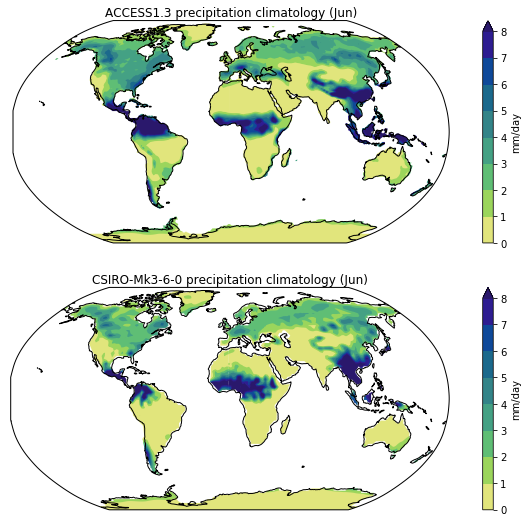

In [98]:
# Command line selections

levels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
month = 'Jun'

projs = {'PlateCarree': ccrs.PlateCarree(),
         'PlateCarree_Dateline': ccrs.PlateCarree(central_longitude=180.0),
         'Mollweide_Dateline': ccrs.Mollweide(central_longitude=180.0),
         'Mollweide': ccrs.Mollweide(),
         'Robinson_Dateline': ccrs.Robinson(central_longitude=180.0),
         'Robinson': ccrs.Robinson(),
         'Orthographic': ccrs.Orthographic(central_longitude=0, central_latitude=0),
        }

# main()

access_pr_clim = calc_climatology(access_pr_file, access_sftlf_file, month=month)
csiro_pr_clim = calc_climatology(csiro_pr_file, csiro_sftlf_file, month=month)

fig = plt.figure(figsize=[12,9])

#nrows, ncols, plotnum, projection=out_proj_object
ax_top = plt.subplot(2, 1, 1, projection=projs['Robinson'])
ax_bottom = plt.subplot(2, 1, 2, projection=projs['Robinson'])

plot_data(ax_top, access_pr_clim, levels, month)
plot_data(ax_bottom, csiro_pr_clim, levels, month)

plt.show()